# import modules

In [1]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [72]:
import os
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
from nilearn import image, input_data
from nilearn import plotting
import nilearn
import nibabel as nib

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
pwd

'/share/home/connectome/stellasybae/rsfMRIQC/nilearn_clearing'

# apply atlas, high & low pass filtering, confounds correction

In [57]:
data_dir = '/share/home/connectome/stellasybae/rsfMRIQC/nilearn_clearing'

In [58]:
file_atlas = 'atlas-harvardoxford_cort-maxprob-thr25.nii'

In [74]:
img_input_raw = nib.load('/share/scratch/bigdata/ABCD/abcd-fmriprep-task/sub-NDARINVWWCYEZFZ_ses-baselineYear1Arm1_task-rest_run-1_space-MNIPediatricAsym_cohort-4_res-2_desc-preproc_bold.nii') #raw

In [103]:
# npy로 바꾸는+cleaning 하는 코드
def extract_atlas_timeseries(file_atlas, raw_img_input, data_dir):
    file_output = 'cleaned_fmriprep_NDARINVWWCYEZFZ_HarvardOxford_timeseries_headmovecorrected_202111161908.npy'
    img_input = raw_img_input.slicer[:, :, :, 10:]
    
    masker = input_data.NiftiLabelsMasker(labels_img = os.path.join(data_dir, file_atlas), verbose = 1, low_pass=0.04, high_pass=0.009, t_r = 0.8, standardize=True)
    
    #masker.fit_transform(img_input)
    
    confound_files = 'sub-NDARINVWWCYEZFZ_ses-baselineYear1Arm1_task-rest_run-01_motion.tsv'
    confound_df = pd.read_csv(confound_files, delimiter='\t')
    drop_confound_df = confound_df.loc[10:]
    drop_confound_df = drop_confound_df.iloc[:, 1:]
    confounds_matrix = drop_confound_df.values
    
    masker.fit()
    masker.transform(img_input, confounds = confounds_matrix)
    
    masker.generate_report()
    ts = masker.transform(img_input, confounds = confounds_matrix)
    
    np.save(str(file_output),ts)

In [104]:
extract_atlas_timeseries(file_atlas,img_input_raw, data_dir) #head correction + filtering + TR

[NiftiLabelsMasker.fit] loading data from /share/home/connectome/stellasybae/rsfMRIQC/nilearn_clearing/atlas-harvardoxford_cort-maxprob-thr25.nii
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(99, 117, 95, 373),
affine=array([[   2. ,    0. ,    0. ,  -98.5],
       [   0. ,    2. ,    0. , -134.5],
       [   0. ,    0. ,    2. ,  -72.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(99, 117, 95, 373),
affine=array([[   2. ,    0. ,    0. ,  -98.5],
       [   0. ,    2. ,    0. , -134.5],
       [   0. ,    0. ,    2. ,  -72.5],
       [   0. ,    0. ,    0. ,    1. ]])
)
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


# heatmap

In [105]:
data=np.load('cleaned_fmriprep_NDARINVWWCYEZFZ_HarvardOxford_timeseries_headmovecorrected_202111161908.npy')

In [106]:
data

array([[-0.19296065,  0.07058105,  0.22147495, ...,  0.16987297,
         0.14899461,  0.21252882],
       [ 0.00648517, -0.1217384 ,  0.180898  , ...,  0.15354069,
        -0.14230706,  0.27941558],
       [ 0.19636437, -0.31397286,  0.13529423, ...,  0.13406922,
        -0.42669496,  0.34435165],
       ...,
       [ 0.82969767,  0.28073245,  0.18995148, ...,  0.63787454,
        -0.5281854 ,  0.26660657],
       [ 0.71345824,  0.26770124,  0.16961686, ...,  0.56071436,
        -0.38109457,  0.2332982 ],
       [ 0.5892297 ,  0.24892779,  0.14991538, ...,  0.4753465 ,
        -0.23730856,  0.19561103]], dtype=float32)

In [107]:
data.shape

(373, 48)

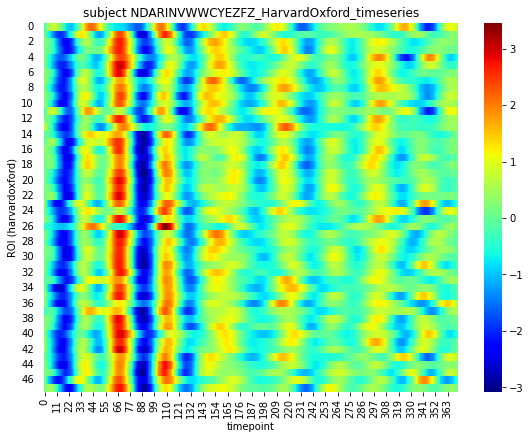

In [108]:
f, ax = plt.subplots(figsize=(8, 6))
plt.tick_params(bottom='on')

ax = sn.heatmap(data.T, cmap='jet', cbar=True) #초반 outlier는 제외하였습니다.
cbar_kws={"orientation": "horizontal", "pad":0.15}
ax.tick_params(axis='y', length=0, labelrotation=0, pad=10)
ax.set_ylabel('ROI (harvardoxford)')
ax.set_xlabel('timepoint')

plt.tight_layout() # 이미 z scoring 된 값!

plt.title('subject NDARINVWWCYEZFZ_HarvardOxford_timeseries')
plt.show()

원래 데이터랑 비교해보면...

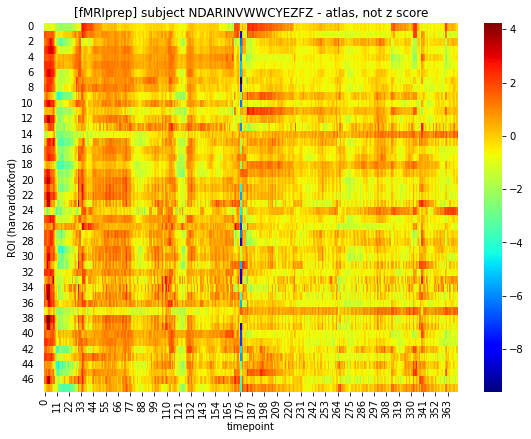

# ROI별 timeseries

In [109]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['font.size'] = 12

def plot_series(time, series, format="-", start=0, end=371, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [110]:
time = [i for i in range(373)]

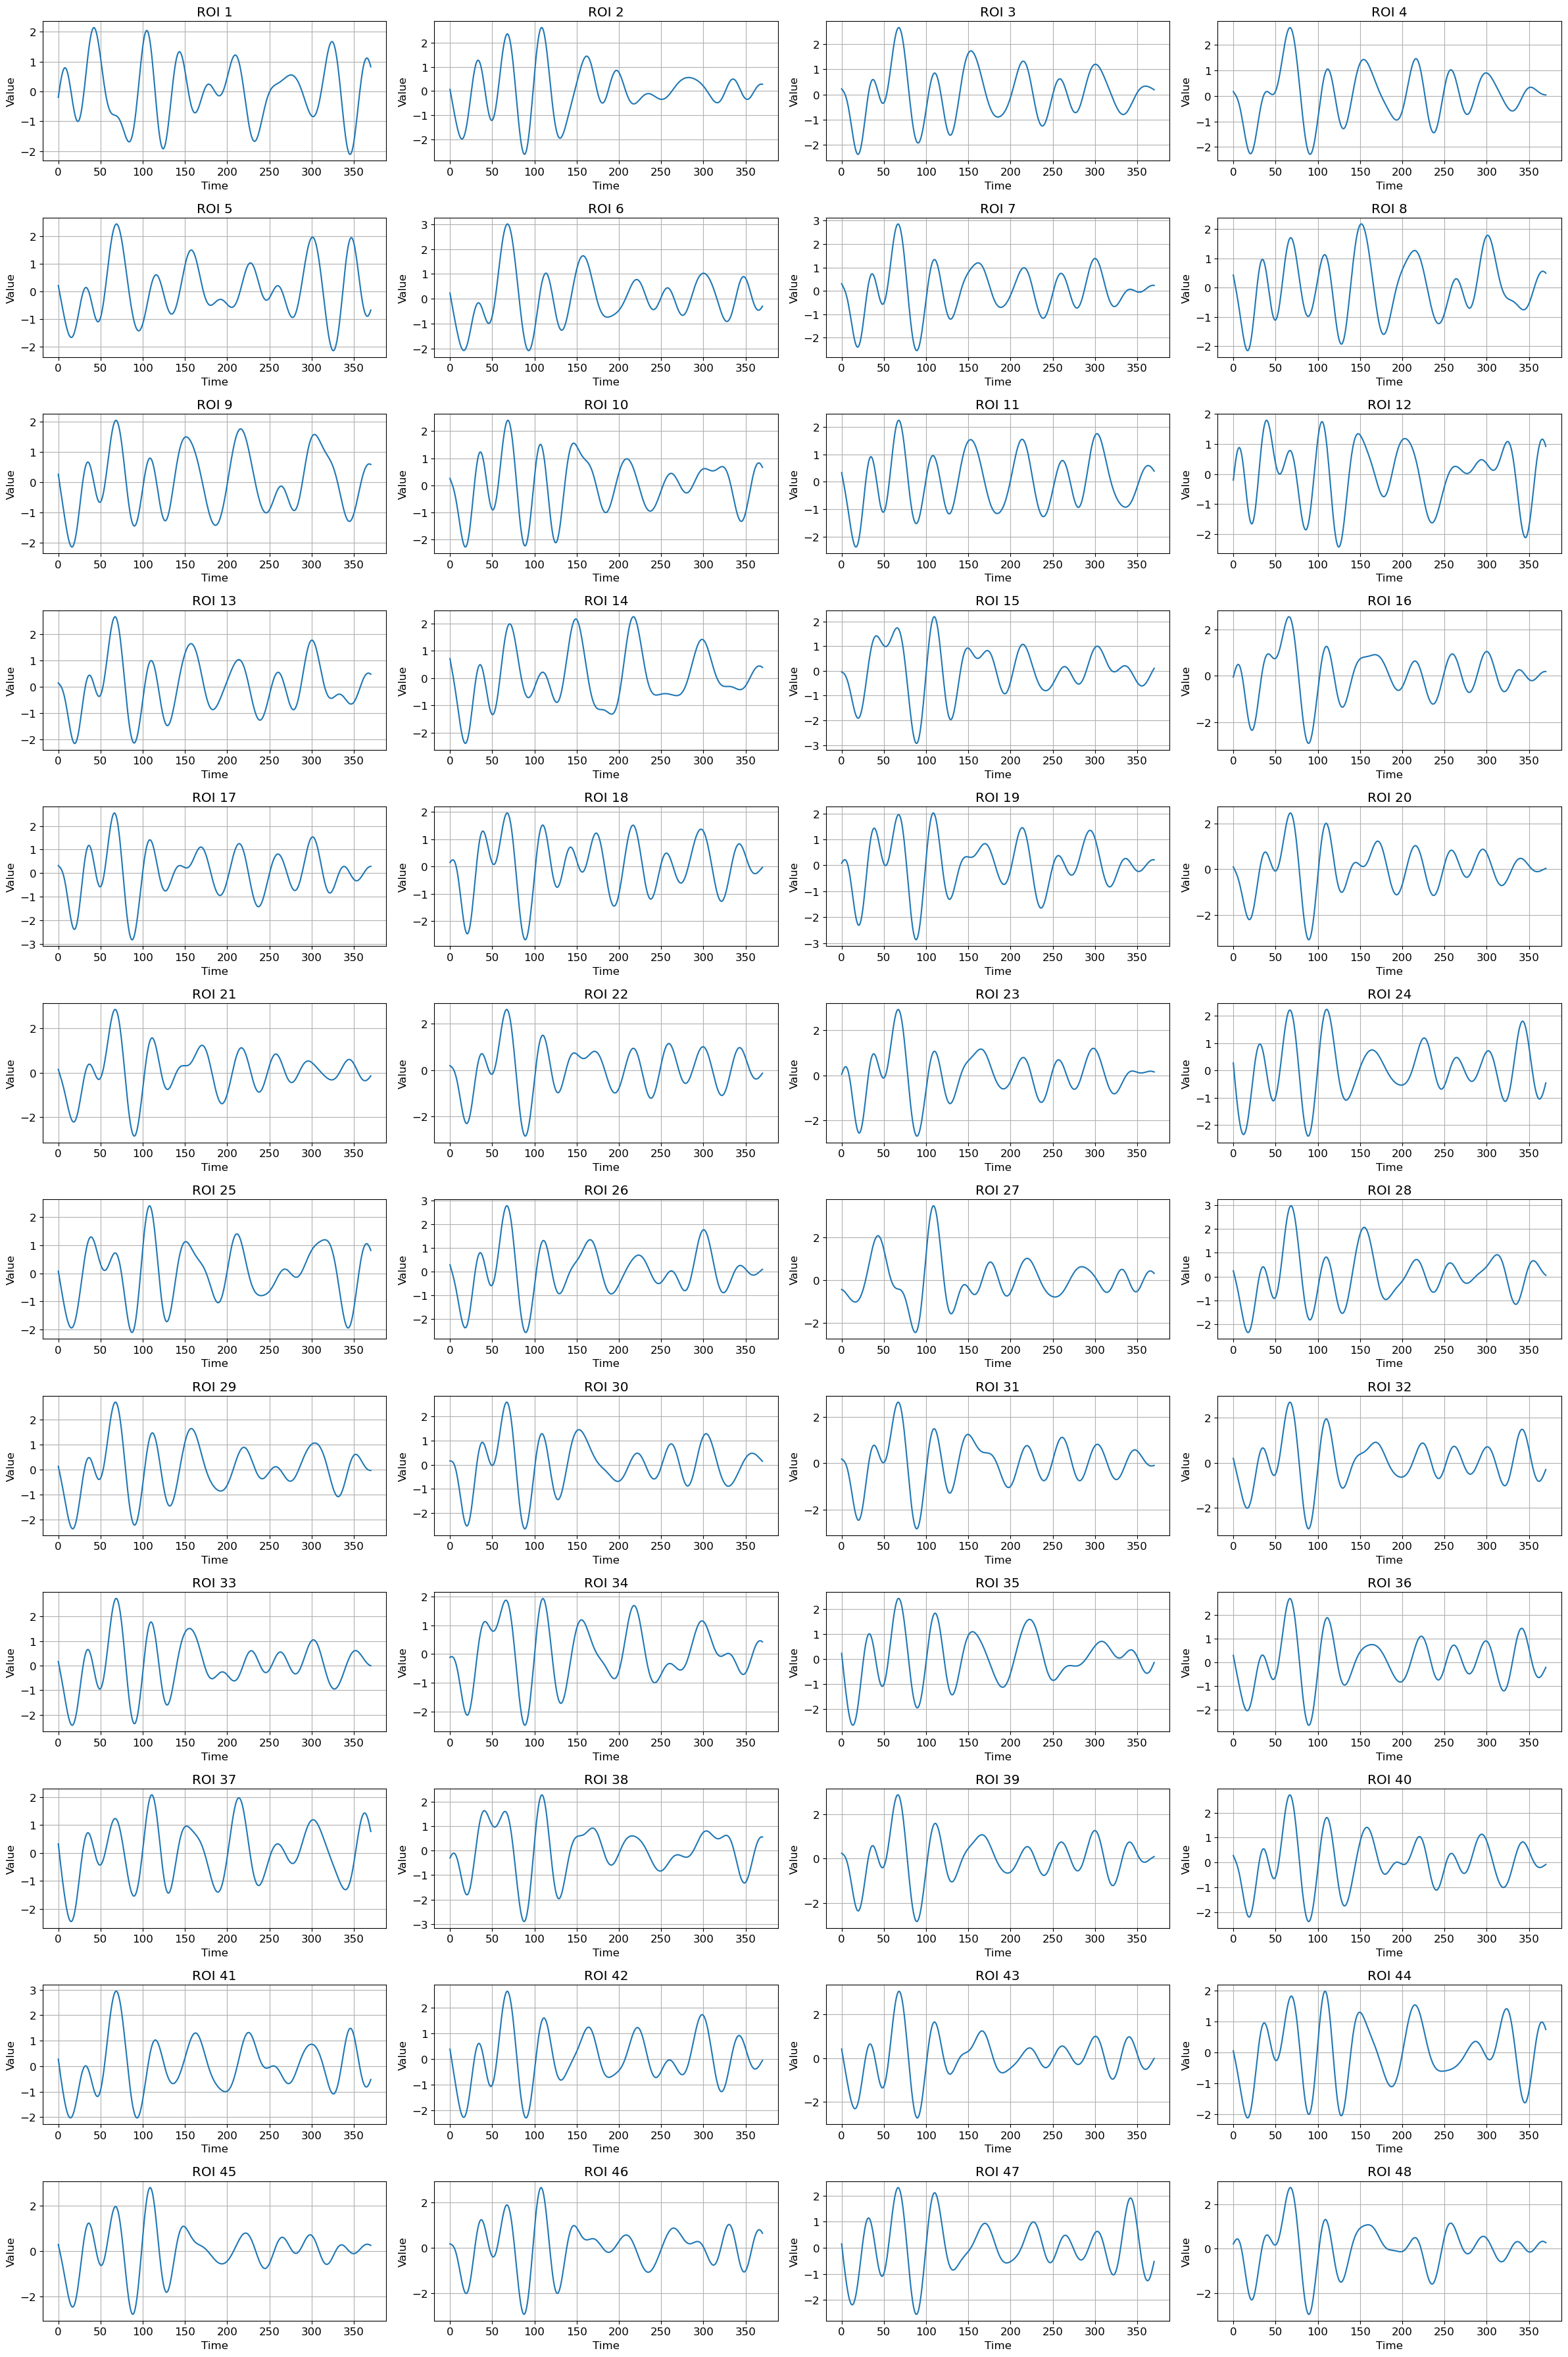

In [111]:
plt.figure(figsize=(24,36))

for i in range(data.shape[1]):
    ax = plt.subplot(12,4,i+1)
    plt.title("ROI %s" % (i+1))
    plot_series(time, data[:, i])
plt.tight_layout()
plt.show()